In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/working'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Data preprocessing**

In [2]:
import tarfile

# Replace 'your_file.tgz' with the actual name of your uploaded file
file_path = '/kaggle/input/lfw-dataset/lfw-funneled.tgz'

with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall('/kaggle/working/Raw/')

In [3]:
def identity(x):
    return x

In [4]:
import os
import tqdm
import re
import numpy as np
import matplotlib.image as mpimg
from typing import Any, Callable

class LazyData:
    def __init__(
        self,
        filename: str,
        load_strategy: str | Callable[[str | bytes], Any] | None = None,
    ):
        self._filename = filename
        self._data = None
        self._load_strategy = load_strategy

    def __call__(self):
        if self._data is None:
            self._build_data()
        return self._data

    def __load_strategy_image(buf) -> np.ndarray[np.uint8]:
        img = mpimg.imread(buf, format="jpg")
        return img

    def _build_data(self):
        with open(self._filename, "rb") as f:
            if self._load_strategy is None:
                self._data = f.read()
            elif self._load_strategy == "image":
                self._data = LazyData.__load_strategy_image(self._filename)
            else:
                buf = f.read()
                self._data = self._load_strategy(buf)


def dataset(
    path: str,
    min_faces: int | None = 20,
    max_faces: int | None = None,
    hard_limit: bool = False,
    shuffle: bool = True,
    random_state: int | None = None,
    verbose: bool | None = True,
):
    if random_state is not None:
        np.random.seed(random_state)

    excluded_dirs = []
    capped_dirs = []
    capped_counts = {}
    for direc in os.listdir(path):
        if os.path.isdir(os.path.join(path, direc)):
            if min_faces is not None:
                if len(os.listdir(os.path.join(path, direc))) < min_faces:
                    excluded_dirs.append(direc)
            if max_faces is not None:
                if len(os.listdir(os.path.join(path, direc))) > max_faces:
                    if hard_limit:
                        excluded_dirs.append(direc)
                    else:
                        capped_dirs.append(direc)

    ds = []
    tracker = tqdm.tqdm if verbose else identity
    pattern = re.compile(r"(.*)_(?:\d{4}).jpg")

    for root, dirs, files in tracker(os.walk(path)):
        for file in files:
            if file.endswith(".jpg"):
                match = pattern.match(file)
                if match:
                    target = match.group(1)

                if target in excluded_dirs:
                    continue

                if max_faces is not None:
                    if target in capped_dirs:
                        if target not in capped_counts:
                            capped_counts[target] = 0
                        capped_counts[target] += 1
                        if capped_counts[target] > max_faces:
                            continue

                ds.append(
                    [
                        LazyData(
                            os.path.abspath(os.path.join(root, file)),
                            load_strategy="image",
                        ),
                        target,
                    ]
                )

    if shuffle:
        np.random.shuffle(ds)

    return np.array(ds)


def fetch_lfw_people(
    min_faces: int | None = 20,
    max_faces: int | None = None,
    hard_limit: bool = False,
    shuffle: bool = True,
    random_state: int | None = None,
    verbose: bool = True,
):
    dst = dataset(
        "/kaggle/working/Raw/lfw_funneled",
        min_faces=min_faces,
        max_faces=max_faces,
        hard_limit=hard_limit,
        shuffle=shuffle,
        random_state=random_state,
        verbose=verbose,
    )
    X = dst[:, 0]
    Y = dst[:, 1]
    return X, Y

In [5]:
import numpy as np
import albumentations as A
from PIL import Image

default_transform = A.Compose(
    [
        A.RandomCrop(width=200, height=200),
        A.HorizontalFlip(p=0.5),
        # A.RandomScale(scale_limit=(-0.5, 2.0), p=0.5),
        A.ShiftScaleRotate(p=0.5, shift_limit=0.1, scale_limit=0.2, rotate_limit=15),
        A.RandomBrightnessContrast(p=0.2),
        A.Blur(blur_limit=3, p=0.2),
    ]
)


def augment_data(
    img: np.ndarray,
    augmentation_count: int = 10,
    augmentation_pipeline=None,
    desired_shape: tuple[int, int] = (250, 250),
) -> list[np.ndarray]:
    images = []
    if augmentation_pipeline is None:
        augmentation_pipeline = default_transform
    for _ in range(augmentation_count):
        aug_image = augmentation_pipeline(image=img)["image"]
        aug_image = Image.fromarray(aug_image).resize(desired_shape)
        aug_image = np.array(aug_image)
        images.append(aug_image)
    return images

In [6]:
from sklearn.model_selection import train_test_split
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from rich import print

# TODO: Documentation


def export_dataset_objects(
    min_faces: int | None = 20,
    max_faces: int | None = None,
    hard_limit: bool = False,
    shuffle=True,
    random_state=None,
    test_size=0.2,
    verbose=True,
    augment=True,
    desired_shape: tuple[int, int] = (250, 250),
    augmentation_count: int = 10,
    augmentation_upto: int | None = None,
    augmentation_pipeline=None,
    experimental_export: bool = False,
):
    X, Y = fetch_lfw_people(
        min_faces=min_faces,
        max_faces=max_faces,
        hard_limit=hard_limit,
        shuffle=shuffle,
        random_state=random_state,
        verbose=verbose,
    )

    tracker = tqdm.tqdm if verbose else identity

    __x = []
    for x in tracker(X):
        __x.append(x())
    # exit(1)

    __x = np.array(__x)

    # TODO: Normalize
    # __x = __x / 255

    x_train, x_test, y_train, y_test = train_test_split(
        __x,
        Y,
        test_size=test_size,
        random_state=random_state,
        stratify=Y,
    )

    if augment:
        if augmentation_upto is None:
            xy = []
            for i, x in tracker(enumerate(x_train)):
                aug_data = augment_data(
                    x,
                    desired_shape=desired_shape,
                    augmentation_count=augmentation_count,
                    augmentation_pipeline=augmentation_pipeline,
                )

                for data in aug_data:
                    data = Image.fromarray(data).convert("L")
                    data = np.array(data)
                    xy.append([data, y_train[i]])
                # print(xy)
                # fig, axes = plt.subplots(2, 5, figsize=(20, 10))
                # axes = axes.flatten()

                # for img, ax in zip(aug_data, axes):
                #     ax.imshow(img)
                #     ax.axis("off")
                # plt.tight_layout()
                # plt.show()

                # exit(1)
            xy_data = np.array(xy, dtype=object)
            x_train_data = xy_data[:, 0]
            print(x_train_data.shape)
            y_train_data = xy_data[:, 1]
            x_train_data = x_train_data / 255
            x_test = x_test / 255
            if not experimental_export:
                x_train_data.dump("/kaggle/working/x_train.npy")
                y_train_data.dump("/kaggle/working/y_train.npy")
                x_test.dump("/kaggle/working/x_test.npy")
                y_test.dump("/kaggle/working/y_test.npy")
            else:
                np.savez_compressed(
                    "/kaggle/working/data.npz",
                    x_train=x_train_data,
                    y_train=y_train_data,
                    x_test=x_test,
                    y_test=y_test,
                )
            # og_data = np.array(__x)
            # og_data.dump("Dataset/x_og.npy")
            # y_data.dump("Dataset/y.npy")
        else:
            xy = []
            idents = {}
            for i, y in enumerate(y_train):
                if y in idents:
                    idents[y].append(i)
                else:
                    idents[y] = [i]

            if augmentation_upto == 0:
                # augment upto max_faces
                if max_faces is None:
                    raise Exception("max_faces must be int if augmentation_upto is 0")

                for y in idents:
                    augmentation_len = max_faces - len(idents[y])
                    for _k in range(augmentation_len):
                        # choose random image
                        random_image = np.random.choice(idents[y])
                        # augment it
                        aug_data = augment_data(
                            x_train[random_image],
                            desired_shape=desired_shape,
                            augmentation_count=1,
                            augmentation_pipeline=augmentation_pipeline,
                        )
                        data = aug_data[0]
                        data = Image.fromarray(data).convert("L")
                        data = np.array(data)
                        # add it to the dataset
                        xy.append([data, y])
            elif augmentation_upto > 0:
                # augment upto augmentation_upto
                faces = len(idents[y])
                if augmentation_upto > faces:
                    for y in idents:
                        augmentation_len = augmentation_upto - len(idents[y])
                        for _k in range(augmentation_len):
                            # choose random image
                            random_image = np.random.choice(idents[y])
                            # augment it
                            aug_data = augment_data(
                                x_train[random_image],
                                desired_shape=desired_shape,
                                augmentation_count=1,
                                augmentation_pipeline=augmentation_pipeline,
                            )
                            data = aug_data[0]
                            data = Image.fromarray(data).convert("L")
                            data = np.array(data)
                            # add it to the dataset
                            xy.append([data, y])
            else:
                raise Exception("augmentation_upto must be bool or int")

            # add the original image with the label
            for i, x in tracker(enumerate(x_train)):
                cv_image = Image.fromarray(x).convert("L")
                cv_image = np.array(cv_image)
                xy.append([cv_image, y_train[i]])

            xy_data = np.array(xy, dtype=object)
            x_train_data = xy_data[:, 0]
            print(x_train_data.shape)
            y_train_data = xy_data[:, 1]
            x_train_data = x_train_data / 255
            x_test = x_test / 255

            if not experimental_export:
                x_train_data.dump("/kaggle/working/x_train.npy")
                y_train_data.dump("/kaggle/working/y_train.npy")
                x_test.dump("/kaggle/working/x_test.npy")
                y_test.dump("/kaggle/working/y_test.npy")
            else:
                np.savez_compressed(
                    "/kaggle/working/data.npz",
                    x_train=x_train_data,
                    y_train=y_train_data,
                    x_test=x_test,
                    y_test=y_test,
                )

    else:
        # x_data = np.array(__x)
        # x_data.dump("Dataset/x.npy")
        # Y.dump("Dataset/y.npy")
        x_train = x_train / 255
        print(x_train.shape)
        x_test = x_test / 255

        if not experimental_export:
            x_train.dump("/kaggle/working/x_train.npy")
            y_train.dump("/kaggle/working/y_train.npy")
            x_test.dump("/kaggle/working/x_test.npy")
            y_test.dump("/kaggle/working/y_test.npy")
        else:
            np.savez_compressed(
                "/kaggle/working/data.npz",
                x_train=x_train,
                y_train=y_train,
                x_test=x_test,
                y_test=y_test,
            )

In [25]:
export_dataset_objects(
        shuffle=False,
        min_faces=20,
        max_faces=None,
        hard_limit=False,
        augment=True,
        augmentation_upto=250,
        experimental_export=True,
    )

5750it [00:00, 7694.23it/s] 
100%|██████████| 3023/3023 [00:01<00:00, 1635.89it/s]
2418it [00:00, 7957.91it/s]


(15674,)

# **Data Feature extraction**

In [26]:
# loaded_data = np.load('/kaggle/input/face-set1/compressed_x_test.npz',allow_pickle=True)['data']

In [27]:
data = np.load("/kaggle/working/data.npz", allow_pickle=True)

In [10]:
X = data['x_train']
Y = data['y_train']
x_test = data['x_test']
y_test = data['y_test']

In [11]:
X.shape

(15674,)

In [12]:
from collections import Counter

label_counts = Counter(Y)

for label, count in label_counts.items():
    print(f"Label {label}: {count} images")

Label Donald_Rumsfeld: 250 images

Label Colin_Powell: 250 images

Label Paul_Bremer: 250 images

Label Gray_Davis: 250 images

Label Tony_Blair: 250 images

Label Gerhard_Schroeder: 250 images

Label Hans_Blix: 250 images

Label Kofi_Annan: 250 images

Label Laura_Bush: 250 images

Label Ricardo_Lagos: 250 images

Label Megawati_Sukarnoputri: 250 images

Label Arnold_Schwarzenegger: 250 images

Label Jennifer_Capriati: 250 images

Label Gloria_Macapagal_Arroyo: 250 images

Label Recep_Tayyip_Erdogan: 250 images

Label Rudolph_Giuliani: 250 images

Label George_Robertson: 250 images

Label Ariel_Sharon: 250 images

Label Serena_Williams: 250 images

Label Naomi_Watts: 250 images

Label Jennifer_Aniston: 250 images

Label Junichiro_Koizumi: 250 images

Label Luiz_Inacio_Lula_da_Silva: 250 images

Label Jose_Maria_Aznar: 250 images

Label Michael_Bloomberg: 250 images

Label Jiang_Zemin: 250 images

Label Carlos_Menem: 250 images

Label David_Beckham: 250 images

Label Angelina_Jolie: 250 images

Label Tiger_Woods: 250 images

Label Lindsay_Davenport: 250 images

Label Jacques_Chirac: 250 images

Label Vladimir_Putin: 250 images

Label Hugo_Chavez: 250 images

Label Pete_Sampras: 250 images

Label Tom_Ridge: 250 images

Label Juan_Carlos_Ferrero: 250 images

Label Jeremy_Greenstock: 250 images

Label Lleyton_Hewitt: 250 images

Label Alejandro_Toledo: 250 images

Label Alvaro_Uribe: 250 images

Label Andre_Agassi: 250 images

Label Jean_Chretien: 250 images

Label Mahmoud_Abbas: 250 images

Label Roh_Moo-hyun: 250 images

Label John_Ashcroft: 250 images

Label Hamid_Karzai: 250 images

Label Atal_Bihari_Vajpayee: 250 images

Label Amelie_Mauresmo: 250 images

Label Vicente_Fox: 250 images

Label Tom_Daschle: 250 images

Label Nestor_Kirchner: 250 images

Label Igor_Ivanov: 250 images

Label Jack_Straw: 250 images

Label John_Negroponte: 250 images

Label Guillermo_Coria: 250 images

Label Jennifer_Lopez: 250 images

Label Winona_Ryder: 250 images

Label Silvio_Berlusconi: 250 images

Label Bill_Clinton: 250 images

Label Saddam_Hussein: 250 images

Label George_W_Bush: 424 images

In [13]:
# Assuming y_train is your list of labels corresponding to x_train
unique_identities = np.unique(Y)

print(f"There are {len(unique_identities)} unique identities.")

There are 62 unique identities.

In [14]:
from collections import Counter

# Assuming y_train is your list of labels corresponding to x_train
label_counts = Counter(Y)

# Find the identity with the least number of images
min_label, min_count = min(label_counts.items(), key=lambda x: x[1])

print(f"Identity {min_label} has the least number of images: {min_count} images")

Identity Donald_Rumsfeld has the least number of images: 250 images

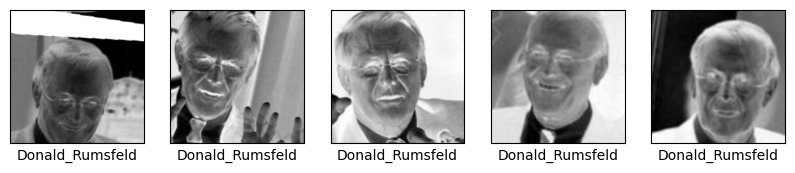

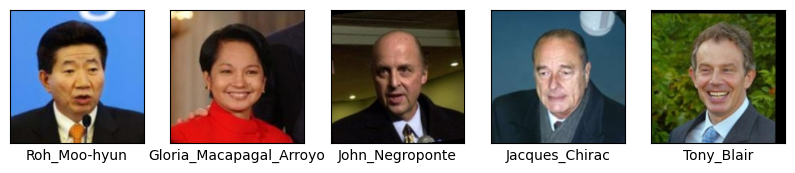

In [15]:
import matplotlib.pyplot as plt

# Function to plot images
def plot_images(images, titles):
    plt.figure(figsize=(10,10))
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(titles[i])
    plt.show()

# Plot images from X
plot_images(X, Y)

# Plot images from x_test
plot_images(x_test, y_test)


In [16]:
import cv2
def normalize_images(image_array):
    # Normalize the images and convert them to 8-bit
    for i, image in enumerate(image_array):
        image = ((image - np.min(image)) / (np.max(image) - np.min(image))) * 255
        image = cv2.convertScaleAbs(image)
        image_array[i] = image
    return image_array

# Apply the function to our X and x_test
X_normalized = normalize_images(X)
x_test_normalized = normalize_images(x_test)


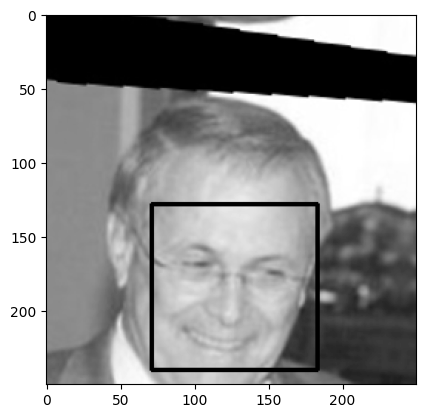

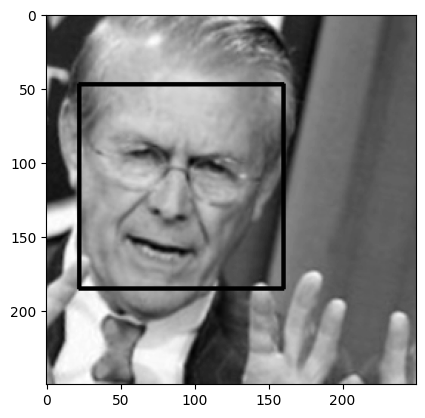

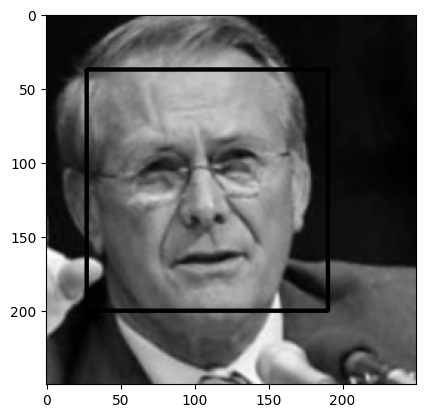

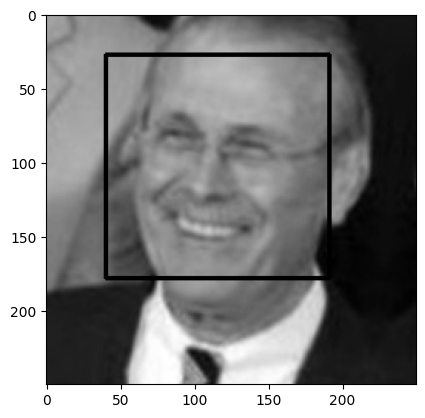

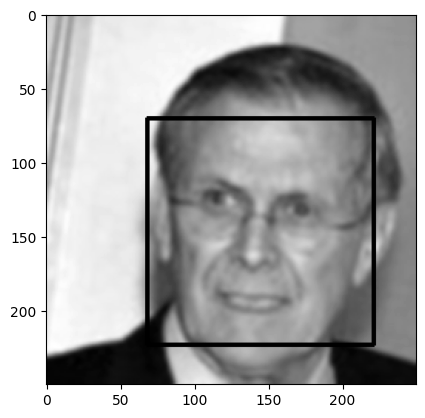

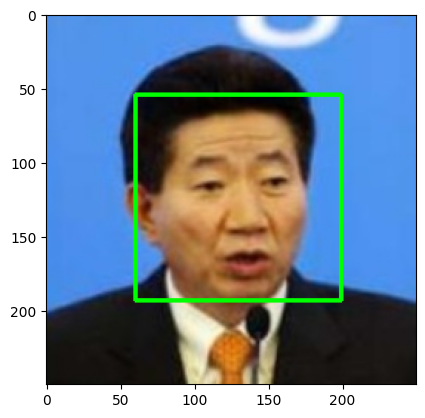

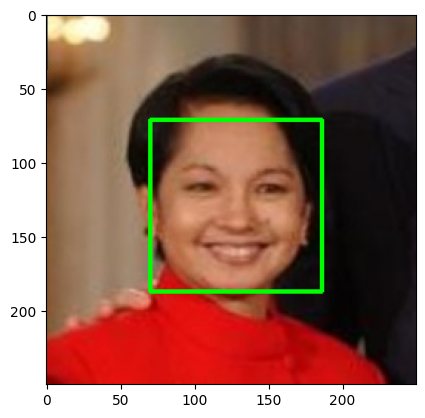

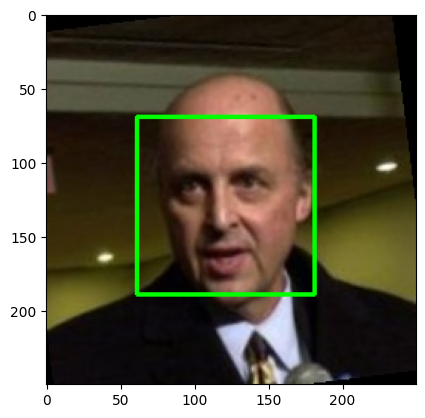

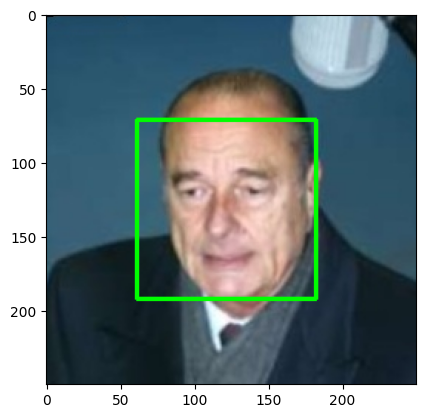

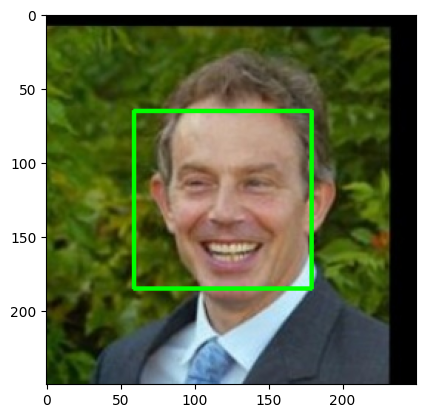

In [17]:
def detect_faces_in_image(input_image):
    # Initialize face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convert the image to 8-bit
    image = cv2.convertScaleAbs(input_image)
    
    # Check if the image is already grayscale
    if len(image.shape) == 3:
        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    for (x, y, w, h) in faces:
        # Draw a rectangle around the face
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.show()

for i, image in enumerate(X_normalized):
    if i < 5:
        detect_faces_in_image(image)

for i, image in enumerate(x_test_normalized):
    if i < 5:
        detect_faces_in_image(image)

In [18]:
def detect_and_crop_faces_in_image(input_image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convert the image to 8-bit
    image = cv2.convertScaleAbs(input_image)
    
    # Check if the image is already grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    # If a face is detected, crop it out
    if len(faces) > 0:
        x, y, w, h = faces[0]
        cropped_face = image[y:y+h, x:x+w]
        return cropped_face
    return image

final_X = []
final_x_test = []

# Call the function with your images
for image in X_normalized:
    cropped_face = detect_and_crop_faces_in_image(image)
    final_X.append(cropped_face) 

for image in x_test_normalized:
    cropped_face = detect_and_crop_faces_in_image(image)
    final_x_test.append(cropped_face)  


In [19]:
from skimage import feature, transform
def extract_hog_features(images):
    hog_features_list = []
    for image in images:
        image_resized = transform.resize(image, (64, 168))
        
        # Check if the image is grayscale or color
        if len(image_resized.shape) == 3 and image_resized.shape[2] == 3:
            # The image is a color image, convert it to grayscale
            image_resized_32 = image_resized.astype(np.float32)
            gray = cv2.cvtColor(image_resized_32, cv2.COLOR_BGR2GRAY)
        else:
            # The image is already grayscale
            gray = image_resized
        
        # Extract HOG features
        hog_features = feature.hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys')
        hog_features_list.append(hog_features)
    
    return hog_features_list


hog_features_X = extract_hog_features(final_X)
hog_features_x_test = extract_hog_features(final_x_test)

In [20]:
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

classifier = {'SVM': svm.SVC()}

# X_train, X_val, y_train, y_val = train_test_split(hog_features_X, Y, test_size=0.2, random_state=42, stratify=Y)



In [21]:
np.array(hog_features_x_test).shape

(605, 5040)

In [22]:
y_test.shape

(605,)

In [23]:

# Train and evaluate the classifier
for name, clf in classifier.items():
    print(f"Training {name}...")
    clf.fit(hog_features_X, Y)
    
    print(f"Evaluating {name} on the validation set...")
    y_pred = clf.predict(hog_features_x_test)
    print(classification_report(y_test, y_pred))
    accuracy_val = accuracy_score(y_test, y_pred)
    print(f"Validation Accuracy: {accuracy_val}")
    
#     print(f"Evaluating {name} on the test set...")
#     y_test_pred = clf.predict(hog_features_x_test)
#     print(classification_report(y_test, y_test_pred))
#     accuracy_test = accuracy_score(y_test, y_test_pred)
#     print(f"Test Accuracy: {accuracy_test}")

Training SVM...

Evaluating SVM on the validation set...

precision    recall  f1-score   support

         Alejandro_Toledo       0.88      0.88      0.88         8
             Alvaro_Uribe       0.80      0.57      0.67         7
          Amelie_Mauresmo       1.00      0.25      0.40         4
             Andre_Agassi       0.58      1.00      0.74         7
           Angelina_Jolie       0.50      0.25      0.33         4
             Ariel_Sharon       0.82      0.88      0.85        16
    Arnold_Schwarzenegger       0.86      0.75      0.80         8
     Atal_Bihari_Vajpayee       0.83      1.00      0.91         5
             Bill_Clinton       0.75      0.50      0.60         6
             Carlos_Menem       1.00      0.75      0.86         4
             Colin_Powell       0.95      0.89      0.92        47
            David_Beckham       0.62      0.83      0.71         6
          Donald_Rumsfeld       0.90      0.79      0.84        24
         George_Robertson       0.60      0.75      0.67         4
            George_W_Bush       0.78      0.88      0.82       106
        Gerhard_Schroeder       0.89      0.73      0.80        22
  Gloria_Macapagal_Arroyo       0.82      1.00      0.90         9
               Gray_Davis       0.29      0.80      0.42         5
          Guillermo_Coria       0.75      1.00      0.86         6
             Hamid_Karzai       0.60      0.75      0.67         4
                Hans_Blix       0.75      0.75      0.75         8
              Hugo_Chavez       0.73      0.79      0.76        14
              Igor_Ivanov       1.00      0.25      0.40         4
               Jack_Straw       0.67      1.00      0.80         6
           Jacques_Chirac       0.69      0.82      0.75        11
            Jean_Chretien       0.89      0.73      0.80        11
         Jennifer_Aniston       0.80      1.00      0.89         4
        Jennifer_Capriati       0.58      0.88      0.70         8
           Jennifer_Lopez       0.67      0.50      0.57         4
        Jeremy_Greenstock       0.67      0.80      0.73         5
              Jiang_Zemin       0.80      1.00      0.89         4
            John_Ashcroft       1.00      0.73      0.84        11
          John_Negroponte       0.75      0.50      0.60         6
         Jose_Maria_Aznar       0.40      0.40      0.40         5
      Juan_Carlos_Ferrero       1.00      0.50      0.67         6
        Junichiro_Koizumi       0.83      0.83      0.83        12
               Kofi_Annan       0.60      1.00      0.75         6
               Laura_Bush       1.00      1.00      1.00         8
        Lindsay_Davenport       0.67      1.00      0.80         4
           Lleyton_Hewitt       1.00      0.62      0.77         8
Luiz_Inacio_Lula_da_Silva       0.90      0.90      0.90        10
            Mahmoud_Abbas       1.00      0.83      0.91         6
    Megawati_Sukarnoputri       1.00      0.86      0.92         7
        Michael_Bloomberg       0.33      0.25      0.29         4
              Naomi_Watts       0.67      0.50      0.57         4
          Nestor_Kirchner       0.45      0.71      0.56         7
              Paul_Bremer       1.00      0.75      0.86         4
             Pete_Sampras       1.00      0.50      0.67         4
     Recep_Tayyip_Erdogan       1.00      0.83      0.91         6
            Ricardo_Lagos       0.67      0.40      0.50         5
             Roh_Moo-hyun       1.00      0.83      0.91         6
         Rudolph_Giuliani       1.00      0.60      0.75         5
           Saddam_Hussein       1.00      0.80      0.89         5
          Serena_Williams       0.82      0.82      0.82        11
        Silvio_Berlusconi       0.75      0.43      0.55         7
              Tiger_Woods       0.60      0.60      0.60         5
              Tom_Daschle       0.75      0.60      0.67         5
                Tom_Ridge       1.00      0.57      0.73         7
               Tony_Blair       0.90      0.90      0.90        29
      

Validation Accuracy: 0.7818181818181819

In [28]:
import pickle
# Specify the directory path
directory_path = '/kaggle/working/model_export/'

# Create the directory if it doesn't exist
os.makedirs(directory_path, exist_ok=True)

with open(os.path.join(directory_path, 'svm_model_3.pkl'), 'wb') as model_file:
    pickle.dump(clf, model_file)